# Library 

In [127]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.metrics import mean_squared_error

# Importing Dataset

In [128]:
training=pd.read_csv('/content/train_IxoE5JN.csv')

In [129]:
testing=pd.read_csv('/content/test_WudNWDM.csv')

In [130]:
training.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [131]:
testing.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


# EDA

In [132]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


In [133]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26304 non-null  int64 
 1   datetime  26304 non-null  object
dtypes: int64(1), object(1)
memory usage: 411.1+ KB


Here for both the data set the date time feature is an object so we have to convert into into datetime format

In [134]:
training['datetime']=pd.to_datetime(training['datetime'])
testing['datetime']=pd.to_datetime(training['datetime'])

In [135]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    94992 non-null  int64         
 1   datetime  94992 non-null  datetime64[ns]
 2   energy    93092 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 2.2 MB


In [136]:
testing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   row_id    26304 non-null  int64         
 1   datetime  26304 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 411.1 KB


**Missing Values**

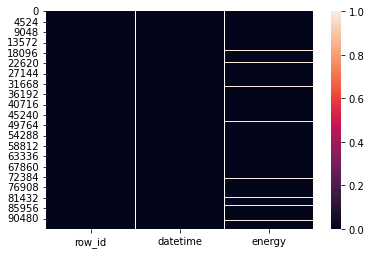

In [137]:
sns.heatmap(training.isnull())

In [138]:
training.isnull().sum()

row_id         0
datetime       0
energy      1900
dtype: int64

There is considerable amount of missing values in the data set.so instead of dropping it we can impliment imputation technique Last observation carried forward. As the enegry demand for the next hour is closely related to the previous hour.

In [139]:
#enegry back filling columns
training['energy_bf']=training['energy'].ffill()

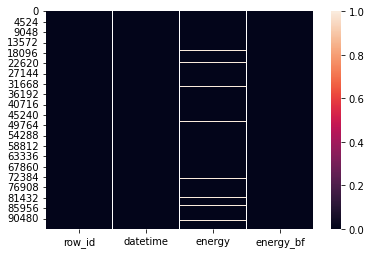

In [140]:
sns.heatmap(training.isnull())

In [141]:
training.isnull().sum()

row_id          0
datetime        0
energy       1900
energy_bf       0
dtype: int64

**Duplicated values**

In [142]:
training.duplicated().sum()

0

There are no missing values in the dataset

**Plots**

In [143]:
#for reset the index ,ploting the energy demand against time 
df1=training.copy()
df1=df1.reset_index()
df1=df1.set_index(df1['datetime'])

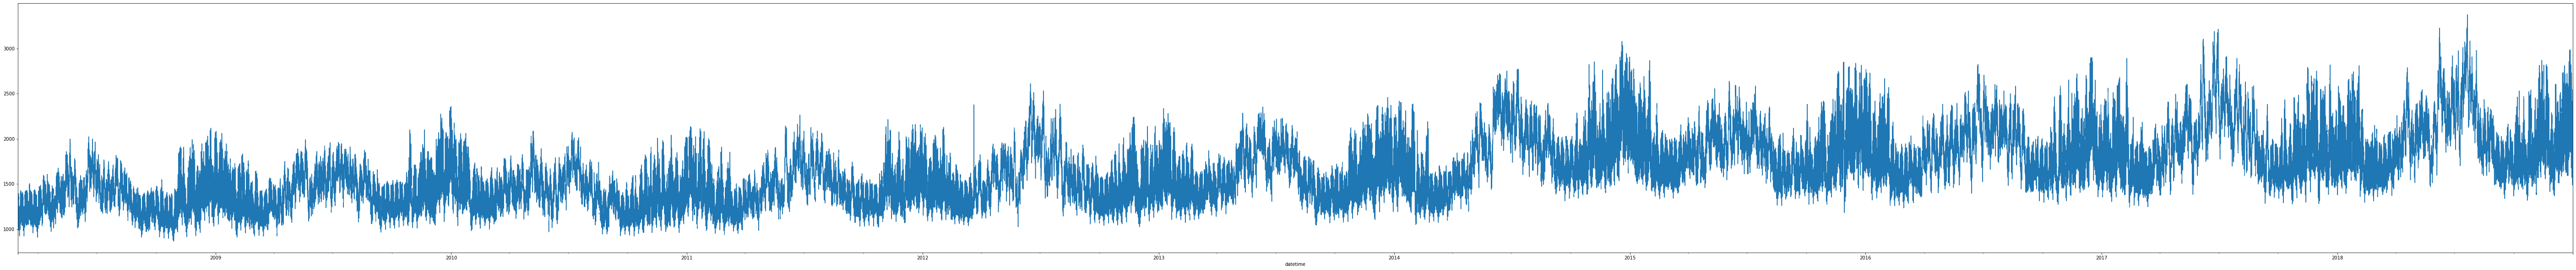

In [144]:
plt.figure(figsize=(100,10))
df1['energy'].plot()

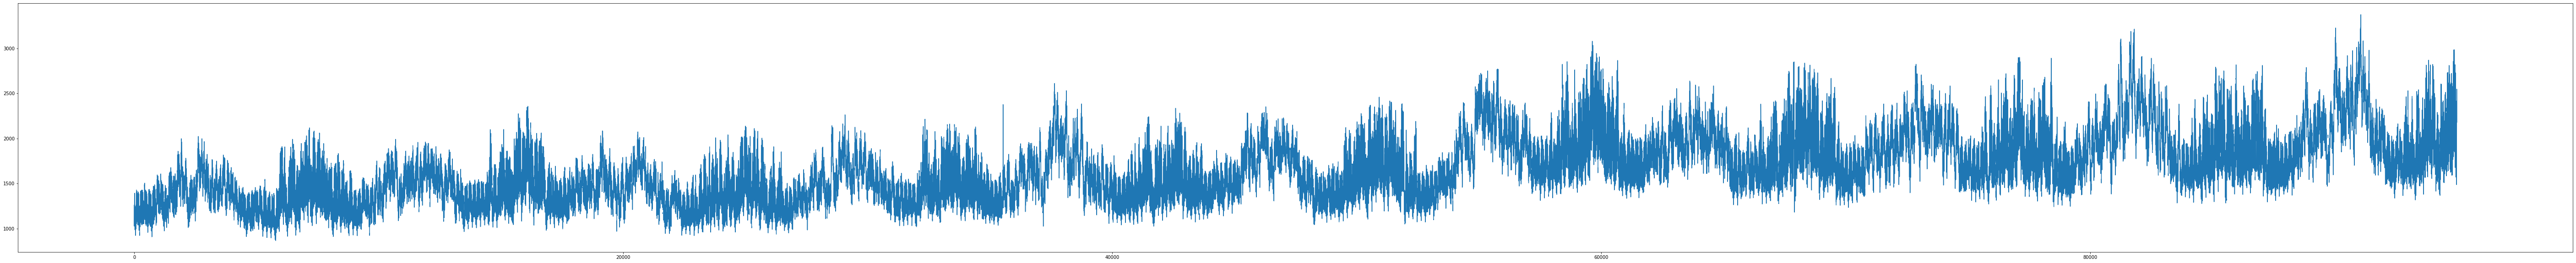

In [145]:
plt.figure(figsize=(100,10))
training['energy'].plot()

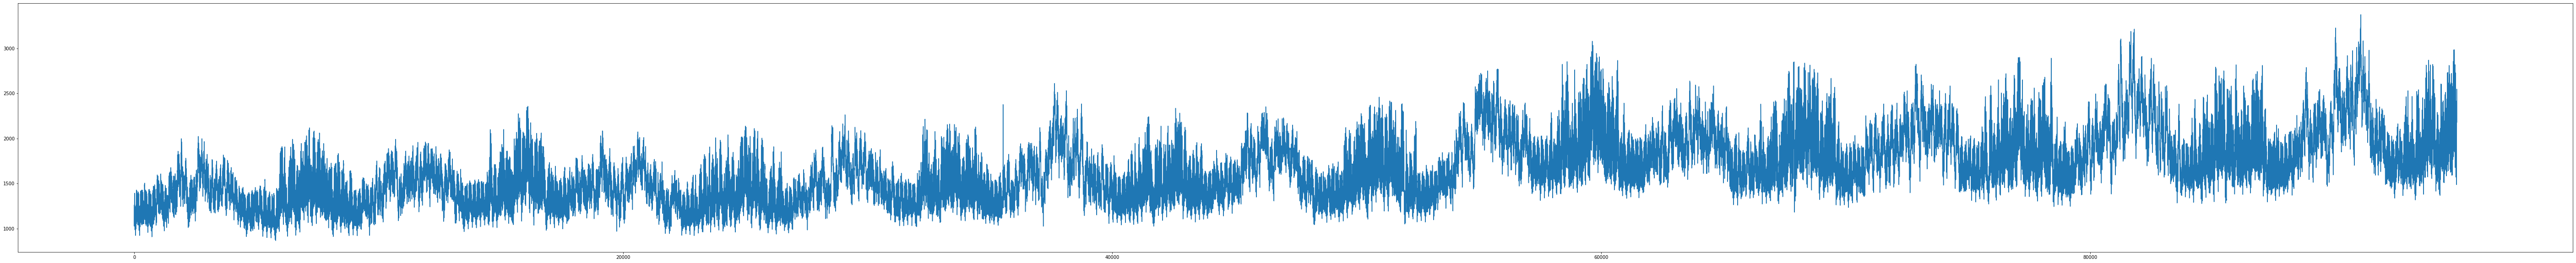

In [146]:
plt.figure(figsize=(100,10))
training['energy_bf'].plot()

Here from the energy demand we can observe that there is seasonality present in the energy,and also a minor increasing trend is observed in the dataset

**Decomposition plots**

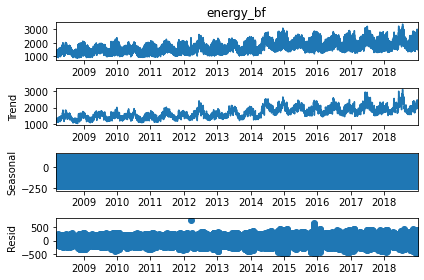

In [147]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp=seasonal_decompose(df1.energy_bf)
decomp.plot()
plt.show()

**Box plot**

In [148]:
df1['year']=pd.DatetimeIndex(df1['datetime']).year
df1['month']=pd.DatetimeIndex(df1['datetime']).month
df1['day']=pd.DatetimeIndex(df1['datetime']).day
df1['hour']=pd.DatetimeIndex(df1['datetime']).hour

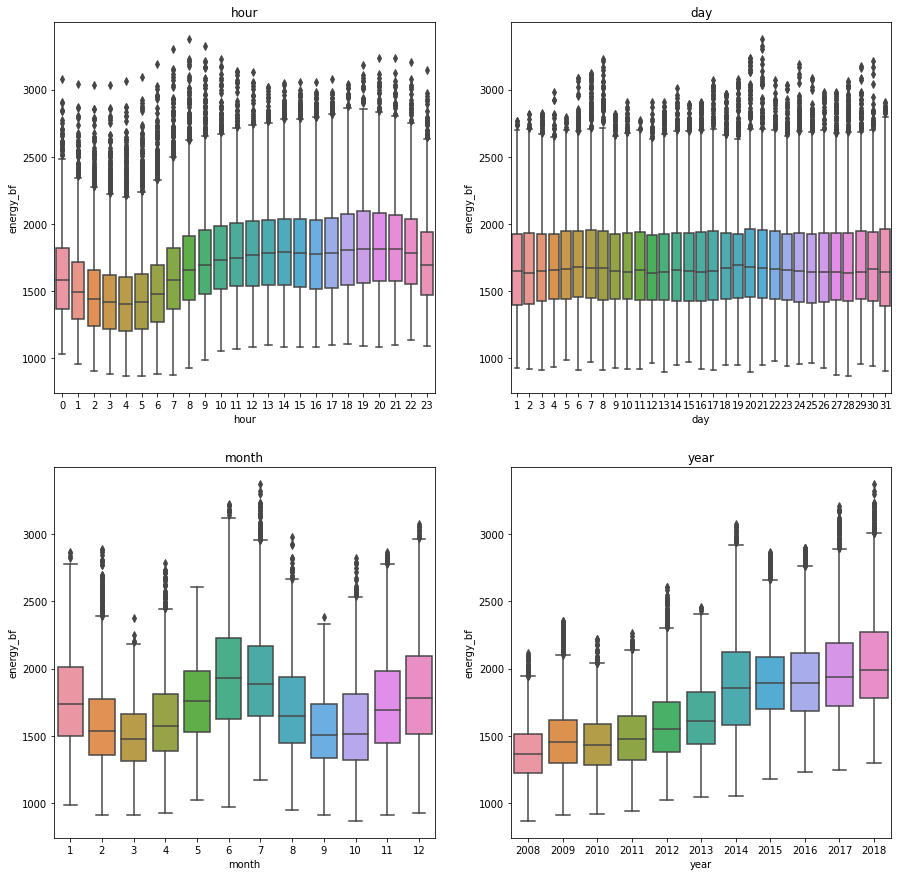

In [149]:
column_names=df1.columns
plt.figure(figsize=(15,15))
for i in range(1,5):
  plt.subplot(2,2,i)
  sns.boxplot(x=column_names[-i],y='energy_bf',data=df1)
  plt.title(column_names[-i])

From the above plots we can infer that the highest demand for energy is observed :
hours basis = 8th hour
day basis = 21st day
month basis = 7th month
year basis = 2018

From the year basis plot we can see that there is an overall increase in the demand.We can also observe less demand during the 2,3,9,10 month of the year.we can observe almost constant median value when looking at the day wise consuption.
Also lesser consuption during the intial 7 hour of the day.

**Pivot Table**

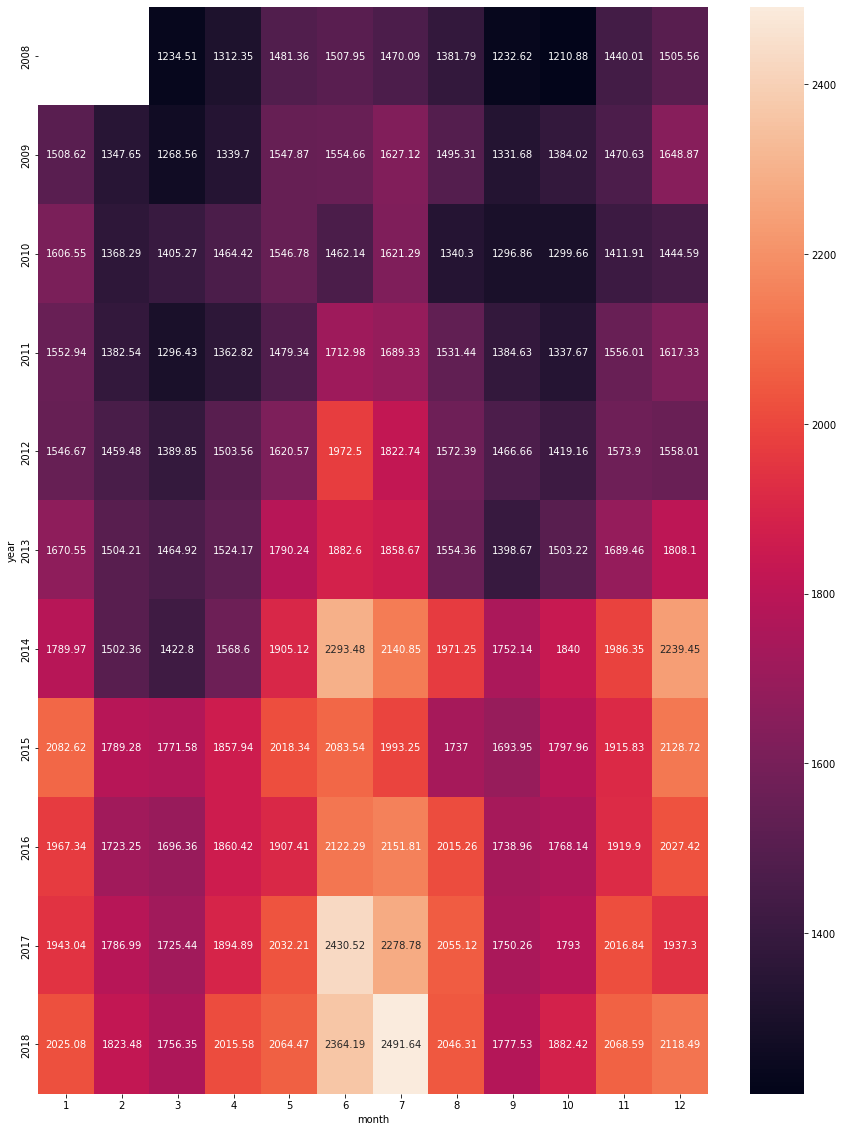

In [150]:
pvt_tbl=df1.pivot_table(index='year',columns='month',values='energy_bf')
plt.figure(figsize=(15,20))
pvt_tbl.fillna(0)
sns.heatmap(pvt_tbl,annot=True,fmt='g')

The highest demand we observed during the 7th month of 2018

# Model building

Transformations

In [151]:
#Selecting the required columns
data=pd.DataFrame()
data['time']=df1['row_id']                #can be considered as time each row corresponds to 1 hrs
data['energy_bf']=df1['energy_bf']        
data["month"] = df1.datetime.dt.strftime("%b")    #extracting month 
data["year"] = df1.datetime.dt.strftime("%Y")     #extracting year
data['day']=df1['day']                             #day
data['time_sq']=data['time']*data['time']          #for quadratic model
data['energy_log']=np.log(df1['energy_bf'])       #exponential model

In [152]:
month=pd.get_dummies(data['month'])          #creating dummies for seasonality 
data=pd.concat([data,month],axis=1)       
data.drop(['month'],axis=1,inplace=True) 

In [153]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        94992 non-null  int64  
 1   energy_bf   94992 non-null  float64
 2   year        94992 non-null  object 
 3   day         94992 non-null  int64  
 4   time_sq     94992 non-null  int64  
 5   energy_log  94992 non-null  float64
 6   Apr         94992 non-null  uint8  
 7   Aug         94992 non-null  uint8  
 8   Dec         94992 non-null  uint8  
 9   Feb         94992 non-null  uint8  
 10  Jan         94992 non-null  uint8  
 11  Jul         94992 non-null  uint8  
 12  Jun         94992 non-null  uint8  
 13  Mar         94992 non-null  uint8  
 14  May         94992 non-null  uint8  
 15  Nov         94992 non-null  uint8  
 16  Oct         94992 non-null  uint8  
 17  Sep         94992 non-null  uint8  
dtypes: float64(2), int64(3), object

In [154]:
data.head()

,time,energy_bf,year,day,time_sq,energy_log,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
datetime,,,,,,,,,,,,,,,,,,
2008-03-01 00:00:00,1,1259.985563,2008,1,1,7.138856,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 01:00:00,2,1095.541500,2008,1,4,6.999004,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 02:00:00,3,1056.247500,2008,1,9,6.962478,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 03:00:00,4,1034.742000,2008,1,16,6.941907,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 04:00:00,5,1026.334500,2008,1,25,6.933749,0,0,0,0,0,0,0,1,0,0,0,0


In [155]:
#Splitting the data
train=data.head(int(len(df1)*.75))
test=data.tail(int(len(df1)*.25))

In [156]:
from statsmodels.tsa.stattools import adfuller
def adf_test(series):
  result=adfuller(series)
  print('ADF statistics : {}'.format(result[0]))
  print('P-value :{}'.format(result[1]))
  if result[1]<=.05:
    print('Strong evidence against the null hypothesis,reject the null hypothesis .data is stationary')
  else:
    print('week evidence againts null hypothesis,data is not stationary')

In [157]:
adf_test(df1['energy_bf'])

ADF statistics : -9.21857073944749
P-value :1.80572427906228e-15
Strong evidence against the null hypothesis,reject the null hypothesis .data is stationary


From the adf test we can conclude the data is stationary

In [158]:
#data frame for comparing the actual vs predicted values
def table(pred,test):
  val=pd.DataFrame()
  val['Prediction']=pred
  val['Actual']=test
  return val

In [159]:
#Ploting function
score=[]
name=[]
def plot(a,b):
  plt.plot(a,label='Actual')
  plt.plot(b,label='Predicted')
  plt.legend()
  return plt

RMSE:= 336.5257075286287


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

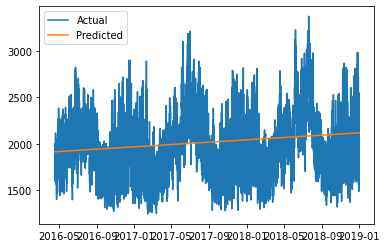

In [160]:
#Linear model
import statsmodels.formula.api as smf
linear_model=smf.ols('energy_bf~time',data=train).fit()
pred=linear_model.predict(test['time'])
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Linear_model')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

RMSE:= 2011.4935049946687


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

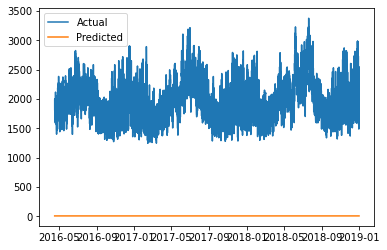

In [161]:
#exponential model
exp=smf.ols('energy_log~time',data=train).fit()
pred=exp.predict(test['time'])
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Exponential_model')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

RMSE:= 401.2619336673201


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

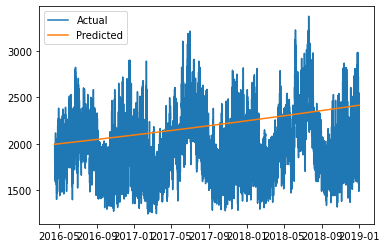

In [162]:
#quadratic model
quadratic=smf.ols('energy_bf~time+time_sq',data=train).fit()
pred=quadratic.predict(test[['time','time_sq']])
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Quadratic_model')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

RMSE:= 478.21143351017764


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

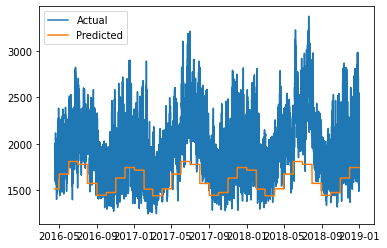

In [163]:
#additive seasonality
add_season=smf.ols('energy_bf~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred=pd.Series(add_season.predict(pd.DataFrame(test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']])))
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('additive_ seasonality')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

RMSE:= 393.6816745993813


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

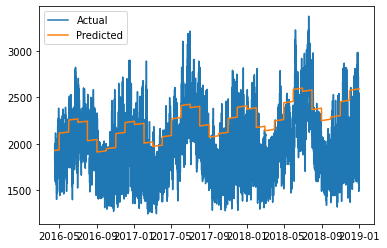

In [164]:
#additive seasonality quadratic
add_season_quadratic=smf.ols('energy_bf~time+time_sq+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=train).fit()
pred=pd.Series(add_season_quadratic.predict(pd.DataFrame(test[['time','time_sq','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']])))
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('additive_ seasonality quadratic')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

RMSE:= 2011.4749104028692


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

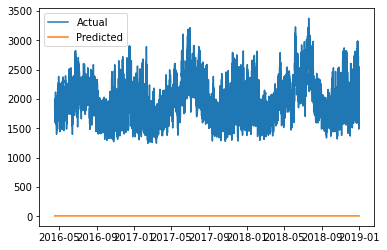

In [165]:
#Multiplicative seasonality 
Mul_Add_sea = smf.ols('energy_log~time+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = train).fit()
pred = pd.Series(Mul_Add_sea.predict(test))
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Multiplicative seasonality quadratic')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

In [166]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 94992 entries, 2008-03-01 00:00:00 to 2018-12-31 23:00:00
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        94992 non-null  int64  
 1   energy_bf   94992 non-null  float64
 2   year        94992 non-null  object 
 3   day         94992 non-null  int64  
 4   time_sq     94992 non-null  int64  
 5   energy_log  94992 non-null  float64
 6   Apr         94992 non-null  uint8  
 7   Aug         94992 non-null  uint8  
 8   Dec         94992 non-null  uint8  
 9   Feb         94992 non-null  uint8  
 10  Jan         94992 non-null  uint8  
 11  Jul         94992 non-null  uint8  
 12  Jun         94992 non-null  uint8  
 13  Mar         94992 non-null  uint8  
 14  May         94992 non-null  uint8  
 15  Nov         94992 non-null  uint8  
 16  Oct         94992 non-null  uint8  
 17  Sep         94992 non-null  uint8  
dtypes: float64(2), int64(3), object

In [167]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing,Holt,ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


RMSE:= 343.2422219391178


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

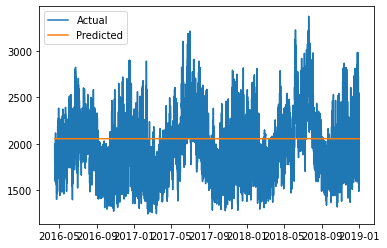

In [168]:
#Simple exponential smoothing
ses=SimpleExpSmoothing(train['energy_bf'],).fit()
pred=ses.predict(start=test.index[0],end=test.index[-1])
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Simple exponential smoothing')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'smoothing_slope'' keyword is deprecated, use 'smoothing_trend' instead
  


RMSE:= 130512.24738007705


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

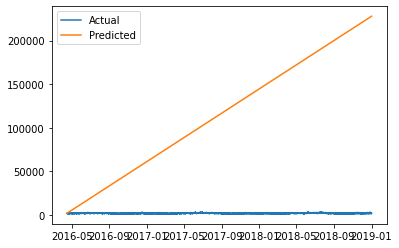

In [169]:
#Holt winter method
hw=Holt(train['energy_bf']).fit(smoothing_level=.6,smoothing_slope=.15)
pred=hw.predict(start=test.index[0],end=test.index[-1])
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Holt method')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


RMSE:= 130512.24738007705


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

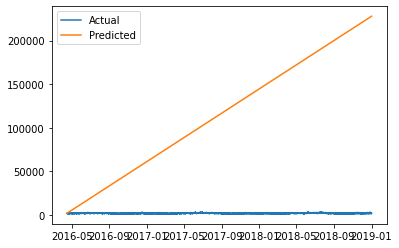

In [170]:
#holt winter with additive seasonality
hwe_add=ExponentialSmoothing(train['energy_bf'],seasonal='add',trend='add',seasonal_periods=24).fit()
pred=hw.predict(start=test.index[0],end=test.index[-1])
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('Holt winter additive seasonality')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

**ARIMA model**

In [171]:
#!pip install pmdarima

In [172]:
from pmdarima import auto_arima

In [173]:
#auto_arima_model=auto_arima(data['energy_bf'],trace=True,suppress_warnings=True)
#auto_arima_model.summary()

In [174]:
data.head()

,time,energy_bf,year,day,time_sq,energy_log,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
datetime,,,,,,,,,,,,,,,,,,
2008-03-01 00:00:00,1,1259.985563,2008,1,1,7.138856,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 01:00:00,2,1095.541500,2008,1,4,6.999004,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 02:00:00,3,1056.247500,2008,1,9,6.962478,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 03:00:00,4,1034.742000,2008,1,16,6.941907,0,0,0,0,0,0,0,1,0,0,0,0
2008-03-01 04:00:00,5,1026.334500,2008,1,25,6.933749,0,0,0,0,0,0,0,1,0,0,0,0


In [175]:
df2=pd.DataFrame()
df2['row']=df1['row_id']
df2['energy_bf']=data['energy_bf']

In [176]:
df2.head()

,row,energy_bf
datetime,,
2008-03-01 00:00:00,1,1259.985563
2008-03-01 01:00:00,2,1095.541500
2008-03-01 02:00:00,3,1056.247500
2008-03-01 03:00:00,4,1034.742000
2008-03-01 04:00:00,5,1026.334500


In [177]:
from statsmodels.tsa.arima.model import ARIMA

In [178]:
train=df2.head(int(len(df2)*.75))
test=df2.tail(int(len(df2)*.25))
model=ARIMA(train['energy_bf'],order=(3,1,3))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


In [179]:
model_fit=model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:606: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [180]:
pred=model_fit.predict(start=len(train),end=len(data)-1)

RMSE:= 337.8181917415942


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

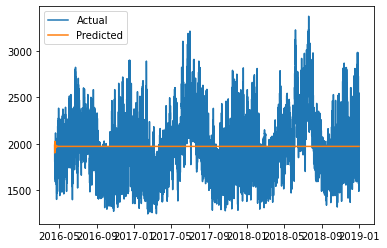

In [181]:
rmse=np.sqrt(mean_squared_error(pred,test['energy_bf']))
score.append(rmse)
name.append('ARIMA')
print('RMSE:=',rmse)
plot(test['energy_bf'],pred)

# Score

In [182]:
scoring=pd.DataFrame()
scoring['Name']=name
scoring['Score']=score

In [183]:
scoring.sort_values('Score')

,Name,Score
0,Linear_model,336.525708
9,ARIMA,337.818192
6,Simple exponential smoothing,343.242222
4,additive_ seasonality quadratic,393.681675
2,Quadratic_model,401.261934
3,additive_ seasonality,478.211434
5,Multiplicative seasonality quadratic,2011.474910
1,Exponential_model,2011.493505
7,Holt method,130512.247380
8,Holt winter additive seasonality,130512.247380


We will select arima as the best model as there is only minor difference between linear model & also arima is a bit advanced model

# Final model

In [184]:
data=pd.read_csv('/content/train_IxoE5JN.csv')
#enegry back filling columns
data['energy_bf']=data['energy'].ffill()

In [185]:
data.drop(['energy','datetime'],axis=1,inplace=True)

In [186]:
data

,row_id,energy_bf
0,1,1259.985563
1,2,1095.541500
2,3,1056.247500
3,4,1034.742000
4,5,1026.334500
...,...,...
94987,94988,2528.446800
94988,94989,2461.883600
94989,94990,2365.994400
94990,94991,2342.942800


In [187]:
#Building the model using the entire data
model=ARIMA(data['energy_bf'],order=(3,1,3))
model_fit=model.fit()

In [188]:
test=pd.read_csv('/content/test_WudNWDM.csv')

In [189]:
#Prediction for the test set given

In [197]:
pred=model_fit.predict(start=len(data)+1,end=(len(test)+len(data)))

In [198]:
pred

94993     1887.755478
94994     1783.253470
94995     1710.589215
94996     1671.679618
94997     1666.737375
             ...     
121292    2139.390805
121293    2139.390805
121294    2139.390805
121295    2139.390805
121296    2139.390805
Name: predicted_mean, Length: 26304, dtype: float64

In [199]:
output=pd.DataFrame(pred)
output=output.reset_index()

In [200]:
output.rename(columns={'index':'row_id','predicted_mean':'energy'},inplace=True)

In [201]:
output.to_csv('submission.csv', index = False, encoding='utf-8') 